In [2]:
import torch

In [3]:
from previous_chapters import GPTModel, generate_text_simple

In [4]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
        # "tensorflow" # For OpenAI's pretrained weights
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.0
numpy version: 1.26.4
tiktoken version: 0.8.0
torch version: 2.5.1


In [5]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length - reduced to support computation
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.3,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [6]:
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.3, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlocks(
      (norm1): LayerNorm()
      (attn): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.3, inplace=False)
      )
      (drop_shortcut): Dropout(p=0.3, inplace=False)
      (norm2): LayerNorm()
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
    )
    (1): TransformerBlocks(
      (norm1): LayerNorm()
      (attn): MultiHeadAttention(
      

In [7]:
import tiktoken

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0)
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)
    return tokenizer.decode(flat.tolist())

In [8]:
#generate_text_simple(model, idx, max_new_tokens, context_size):

In [9]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids(start_context, tokenizer),
    max_new_tokens = 10,
    context_size = GPT_CONFIG_124M['context_length']
)

In [10]:
print("output Text:", token_ids_to_text(token_ids, tokenizer))

output Text: Every effort moves you standing hopelessydْinged Rogers ensl shaky bigot Junk


### Calculating the text generation loss: cross-entropy and perplexity

In [11]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

In [12]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim = -1)
print(probas.shape)

torch.Size([2, 3, 50257])


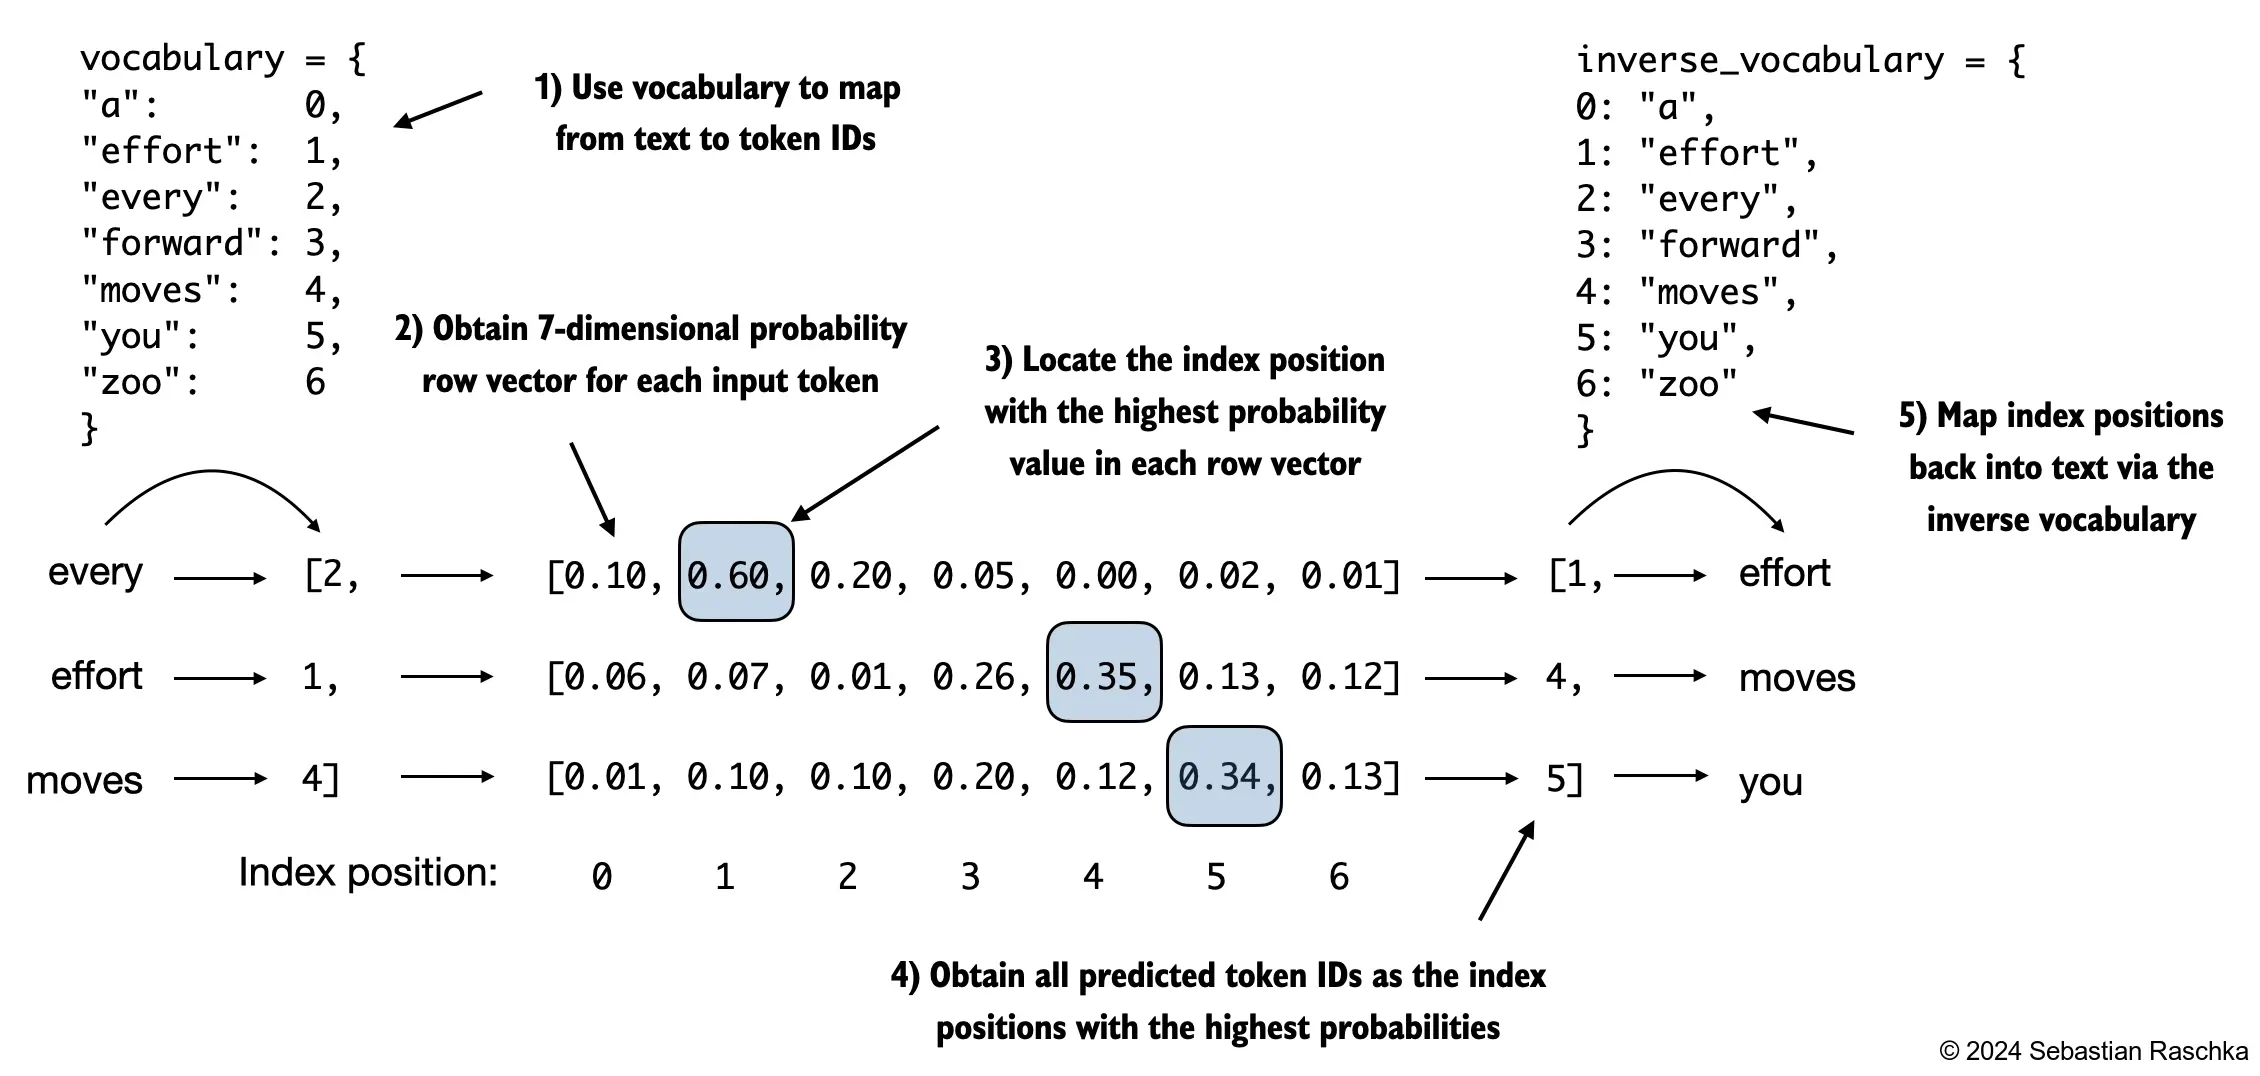

In [13]:
probas

tensor([[[2.8557e-05, 2.7623e-05, 4.9726e-05,  ..., 3.5383e-05,
          1.8204e-05, 1.1545e-05],
         [1.4504e-05, 1.3822e-05, 2.0125e-05,  ..., 1.9038e-05,
          1.2967e-05, 1.5228e-05],
         [1.4216e-05, 2.7390e-05, 2.9836e-05,  ..., 1.8291e-05,
          1.6327e-05, 9.8463e-06]],

        [[1.5892e-05, 2.1407e-05, 4.2127e-05,  ..., 1.8445e-05,
          3.3690e-05, 1.3413e-05],
         [2.7840e-05, 1.5791e-05, 1.2926e-05,  ..., 2.2778e-05,
          8.3156e-06, 2.3035e-05],
         [9.6010e-06, 2.0433e-05, 2.5486e-05,  ..., 3.4390e-05,
          3.5834e-05, 1.5554e-05]]])

In [14]:
# Using argmax we can pop out the vector with the highest probability
pred_token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", pred_token_ids)

Token IDs:
 tensor([[[10258],
         [ 1520],
         [50209]],

        [[19063],
         [ 8068],
         [  479]]])


In [15]:
print("Target Batch 1:", (token_ids_to_text(targets[0], tokenizer)))
print("Predicted Batch 1:", (token_ids_to_text(pred_token_ids[0].flatten(), tokenizer)))

Target Batch 1:  effort moves you
Predicted Batch 1: Color Comm Duff


In [16]:
# These are the Token Probabilities corresponding to the target indices. WHich we need to bring to 1
text_idx = 0
target_probas_1 = probas[text_idx, [0,1,2], targets[text_idx]]
# probas[0, [0,1,2], tensor([3626, 6100,  345])]
print("Text 1:", target_probas_1)

Text 1: tensor([9.1337e-06, 1.0605e-05, 2.6714e-05])


In [17]:
text_idx = 1
target_probas_2 = probas[text_idx, [0,1,2], targets[text_idx]]
# probas[1, [0,1,2], tensor([1107,  588, 11311])]
print("Text 2:", target_probas_2)

Text 2: tensor([6.7241e-06, 1.6274e-05, 1.6583e-05])


- It is easier to maximise the LOG of the probability score than to increase the Probability itself
  

In [18]:
# Compute the Logarithm of the target_probas
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
log_probas

tensor([-11.6035, -11.4542, -10.5303, -11.9098, -11.0260, -11.0071])

In [19]:
avg_log_probas = torch.mean(log_probas)
avg_log_probas

tensor(-11.2552)

### Cross Entropy Loss

In [20]:
neg_avg_log_probas = avg_log_probas * -1
neg_avg_log_probas

tensor(11.2552)

- Logits are the Net Inputs , just before the activation function is applied.

In [21]:
# Logits have shape (batch_size, num_tokens, vocab_size)
print("Logits shape:", logits.shape)

# Targets have shape (batch_size, num_tokens)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [22]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened Logits", logits_flat.shape)
print("Flattened Targets", targets_flat.shape)

Flattened Logits torch.Size([6, 50257])
Flattened Targets torch.Size([6])


- Logits are unscaled outputs before they go to an activation function
- Targets are the TokenID which the LLM has to predict.

In [23]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
loss

tensor(11.2552)

### Perplexity

In [25]:
perplexity = torch.exp(loss)
perplexity

tensor(61383.8672)

## Calculating the training and validation set losses

In [24]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [25]:
text_data[:99]

'I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no '

In [26]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print('TOtal characters', total_characters)
print("Total tokens", total_tokens)

TOtal characters 20479
Total tokens 5145


In [27]:
# Splitting
train_ratio = 0.9
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]

In [28]:
val_data

'ue\' collapsed like a house of cards. He didn\'t sneer, you understand, poor Stroud--he just lay there quietly watching, and on his lips, through the gray beard, I seemed to hear the question: \'Are you sure you know where you\'re coming out?\'\n\n"If I could have painted that face, with that question on it, I should have done a great thing. The next greatest thing was to see that I couldn\'t--and that grace was given me. But, oh, at that minute, Rickham, was there anything on earth I wouldn\'t have given to have Stroud alive before me, and to hear him say: \'It\'s not too late--I\'ll show you how\'?\n\n"It _was_ too late--it would have been, even if he\'d been alive. I packed up my traps, and went down and told Mrs. Stroud. Of course I didn\'t tell her _that_--it would have been Greek to her. I simply said I couldn\'t paint him, that I was too moved. She rather liked the idea--she\'s so romantic! It was that that made her give me the donkey. But she was terribly upset at not getting 

In [29]:
from previous_chapters import create_dataloader_v1
torch.manual_seed(123)

In [30]:
train_loader = create_dataloader_v1(
    train_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = True,
    shuffle = True
)

In [31]:
val_loader = create_dataloader_v1(
    val_data,
    batch_size = 2,
    max_length = GPT_CONFIG_124M["context_length"],
    stride = GPT_CONFIG_124M["context_length"],
    drop_last = False,
    shuffle = False
)

In [32]:
for x, y in train_loader:
    print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])


In [33]:
for x, y in val_loader:
    print(x.shape, y.shape)

torch.Size([2, 256]) torch.Size([2, 256])


In [34]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0,1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches = None):
    total_loss = 0
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        num_batches = min(num_batches, len(data_loader))

    for i , (input_batch, target_batch) in enumerate(data_loader):
        if i< num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss/num_batches

In [35]:
if torch.cuda.is_available():
   device = torch.device("cuda")
elif torch.backends.mps.is_available():
   device = torch.device("mps")
else:
   device = torch.device("cpu")

print(f"Using {device} device.")

Using mps device.


In [36]:
model.to(device)


torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.977733929951986
Validation loss: 10.979158401489258


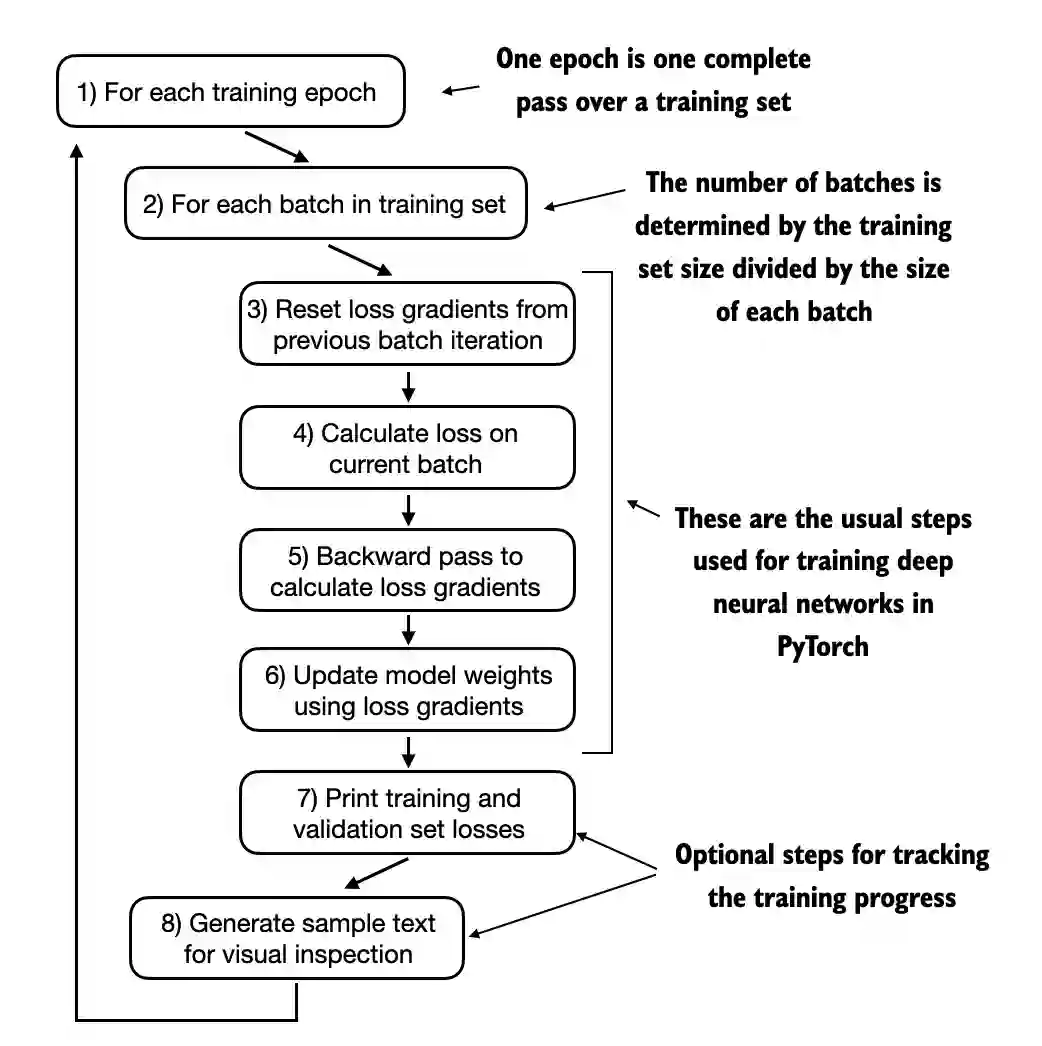

In [37]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):

    train_losses, val_losses , track_tokens_seen = [], [], []
    token_seen, global_step = 0 , -1

    for epoch in range(num_epochs):
        model.train() # Set the model to Train Mode

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset the Loss Gradients from the previous batch iteration

            # Calculate the loss using calc_loss_batch -> returns loss
            loss = calc_loss_batch(input_batch, target_batch, model, device)

            # Calculate Loss Gradients
            loss.backward() 

            # Update Model weights using Loss gradients
            optimizer.step()
            token_seen += input_batch.numel()
            global_step +=1

            # Eval Step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(token_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

            generate_and_print_sample(model, tokenizer, device, start_context)

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches = eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches = eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # Compact print format
    model.train()

In [38]:
# Training the Model


import time
start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="I like to eat and", tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 9.893, Val loss 9.985
I like to eat and the,,,,,,,,,,,,,,,,,,,,,,,,,,, the the,,,,,,,,,,,,,,,,,,,,
I like to eat and                                                  
I like to eat and                                                  
I like to eat and,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
I like to eat and,,,,,,,,,,,,,,,,,,,,,,,,,,,, the,,,,,,,,,,,,,,,,,,,,,
Ep 1 (Step 000005): Train loss 8.117, Val loss 8.359
I like to eat and the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
I like to eat and the, the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
I like to eat and,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
I like to eat and.                       

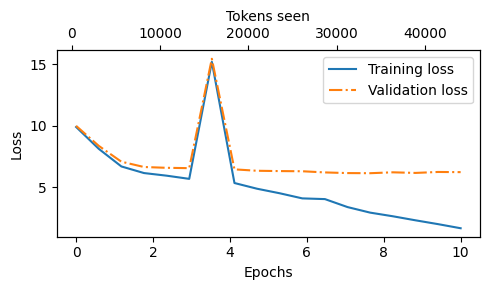

In [39]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [53]:
model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")

In [137]:
token_ids = generate_text_simple(
    model = model,
    idx = text_to_token_ids("Tomorrow is my birthday" , tokenizer),
    max_new_tokens = 25,
    context_size = GPT_CONFIG_124M['context_length']
)

In [138]:
print("output text- \n", token_ids_to_text(token_ids, tokenizer))

output text- 
 Tomorrow is my birthday I had been his pictures--I had been--I turned on the last word.



"I looked,


### Temperature Scaling

In [62]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5, 
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

In [63]:
inverse_vocab = {v:k for k,v in vocab.items()}

In [66]:
# Assuming that when the input is " Every effort moves you"
# The output logits are these. 
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

In [69]:
probas = torch.softmax(next_token_logits, dim = 0)
next_token_id = torch.argmax(probas).item()
next_token_id

3

In [70]:
print(inverse_vocab[next_token_id])

forward


In [127]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


In [136]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # Manual seed for reproducibility
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


- Temperature scaling is just divding the logits by a number > 0

- Temperatures greater than 1 will result in more uniformly distributed token probabilities after applying the softmax
- Temperatures smaller than 1 will result in more confident (sharper or more peaky) distributions after applying the softmax

In [133]:
def softmax_with_temperature(logits, temp):
    scaled_logits = logits / temp
    return torch.softmax(scaled_logits, dim = 0)

In [134]:
temperatures = [1, 0.1, 4]
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]
scaled_probas

[tensor([6.0907e-02, 1.6313e-03, 1.0019e-04, 5.7212e-01, 3.4190e-03, 1.3257e-04,
         1.0120e-04, 3.5758e-01, 4.0122e-03]),
 tensor([1.8530e-10, 3.5189e-26, 2.6890e-38, 9.9099e-01, 5.7569e-23, 4.4220e-37,
         2.9718e-38, 9.0133e-03, 2.8514e-22]),
 tensor([0.1581, 0.0640, 0.0318, 0.2768, 0.0770, 0.0342, 0.0319, 0.2461, 0.0801])]

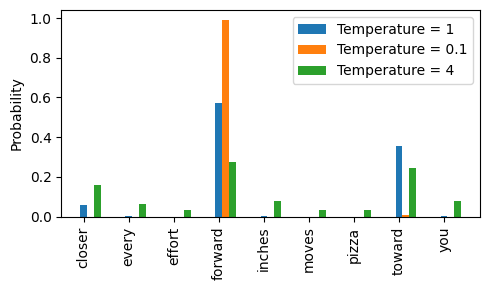

In [135]:
# Plotting
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
# plt.savefig("temperature-plot.pdf")
plt.show()

### Top-k Scaling
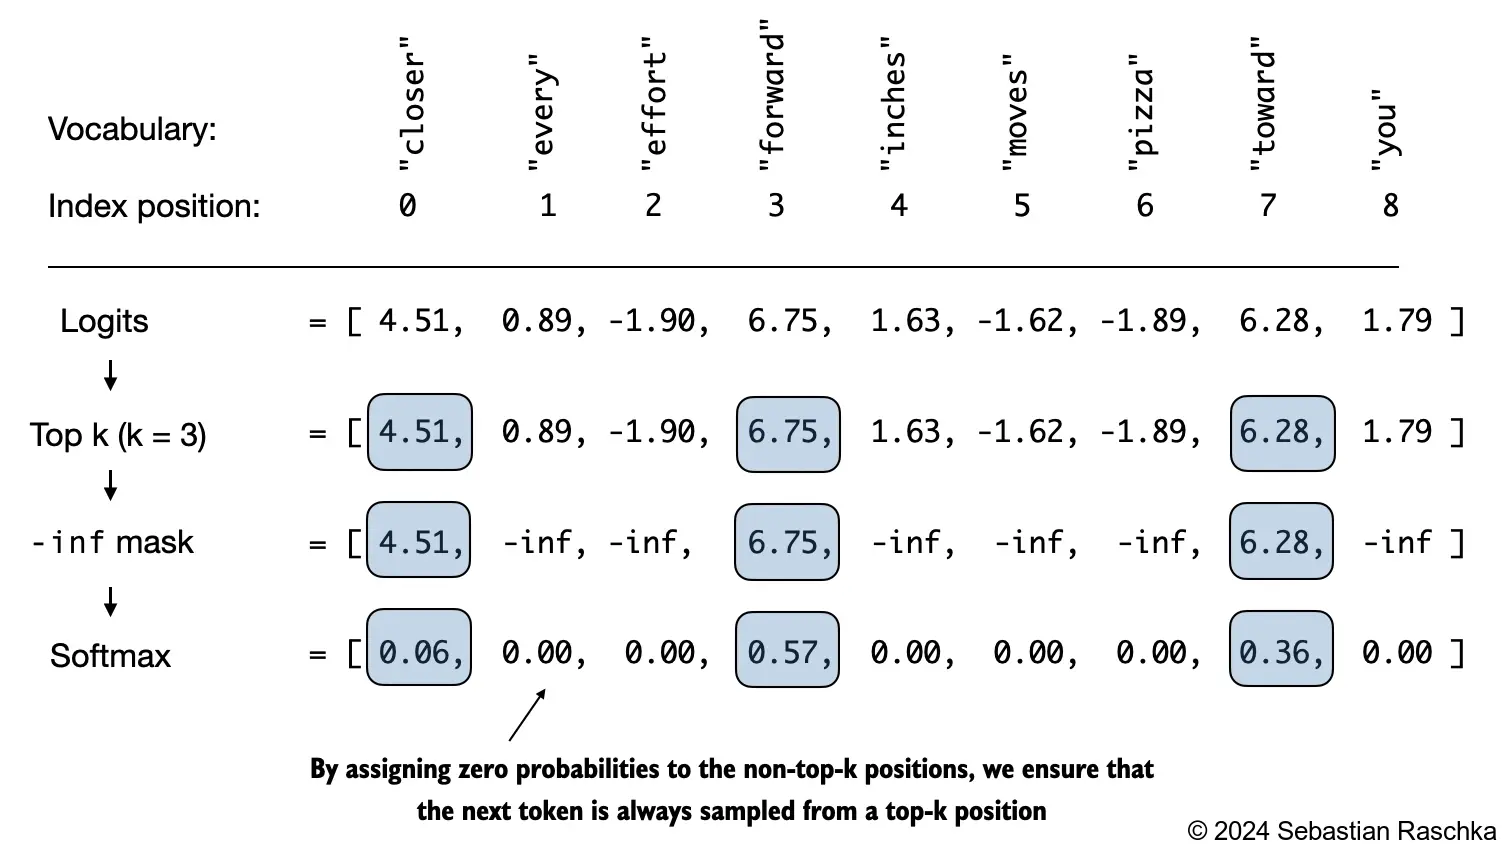

In [140]:
top_k = 5
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top logits:", top_logits)
print("Top positions:", top_pos)

Top logits: tensor([6.7500, 6.2800, 4.5100, 1.7900, 1.6300])
Top positions: tensor([3, 7, 0, 8, 4])


In [141]:
top_logits[-1]

tensor(1.6300)

- torch.topk returns the smallest number at the end of the top_logits

In [143]:
new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float("-inf")),
    other = next_token_logits
)
new_logits

tensor([4.5100,   -inf,   -inf, 6.7500, 1.6300,   -inf,   -inf, 6.2800, 1.7900])

In [144]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0610, 0.0000, 0.0000, 0.5732, 0.0034, 0.0000, 0.0000, 0.3583, 0.0040])


In [160]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # For-loop is the same as before: Get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # New: Filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # New: Apply temperature scaling
        # We won't touch the logits where the temperature is < 0
        if temperature > 0.0:
            logits = logits / temperature

            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # Otherwise same as before: get idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # Stop generating early if end-of-sequence token is encountered and eos_id is specified
            break

        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [168]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=20,
    temperature= 1.3
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you know," was to me a t in his!
I made of my


## Saving Model weights

In [154]:
torch.save(model.state_dict(), "model.pth")

In [156]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval();

# Loading Pre-Trained Weights from GPT2

In [169]:
!pip install tensorflow tqdm

  Using cached rich-13.9.4-py3-none-any.whl.metadata (18 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl.metadata (1.6 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 MB 35.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.1/11.1 MB 37.4 MB/s eta 0:00:00 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.8/25.8 MB 29.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 31.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 32.0 MB/s eta 0:00:00
Using cached rich-13.9.4-py3-none-any.whl (242 kB)
Using cached markdown_it_py-3.0.0-py3-none-any.whl (87 kB)
Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [170]:
print("TensorFlow version:", version("tensorflow"))
print("tqdm version:", version("tqdm"))

TensorFlow version: 2.18.0
tqdm version: 4.67.1


In [178]:
from gpt_download import download_and_load_gpt2

In [179]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json



odel.ckpt.data-00000-of-00001:  42%|██   | 207M/498M [55:52<1:18:38, 61.7kiB/s]

KeyboardInterrupt: 

In [ ]:
print("Settings:", settings)

In [ ]:
print("Parameter dictionary keys:", params.keys())

In [ ]:
print(params["wte"])
print("Token embedding weight tensor dimensions:", params["wte"].shape)